# IMPORT LIBRARIES AND MNIST NUMBER DATASETS

In [1]:
import cv2
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import keras
from tensorflow.keras import regularizers
from keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

def plot_confusion_matrix(cm, target_names, title = "Confusion matrix", cmap = None, normalize = True):
    accuracy = np.trace(cm)/np.sum(cm).astype("float")
    misclass = 1 - accuracy

    if cmap is None : cmap = plt.get_cmap("Blues")
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize: cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label\nAccuracy = {:0.4f}; Misclass = {:0.4f}".format(accuracy, misclass))
    plt.show()

In [2]:
from tensorflow.keras.datasets import mnist
(x_train,y_train), (x_test, y_test) = mnist.load_data()

img_rows = x_train[0].shape[0]
img_cols = x_train[0].shape[1]

In [3]:
print(f"Size of training images : {x_train.shape}")
print(f"Size of training labels : {y_train.shape}")
print(f"Size of testing images  : {x_test.shape}")
print(f"Size of testing labels  : {y_test.shape}")

Size of training images : (60000, 28, 28)
Size of training labels : (60000,)
Size of testing images  : (10000, 28, 28)
Size of testing labels  : (10000,)


# DATA VISUALIZATION

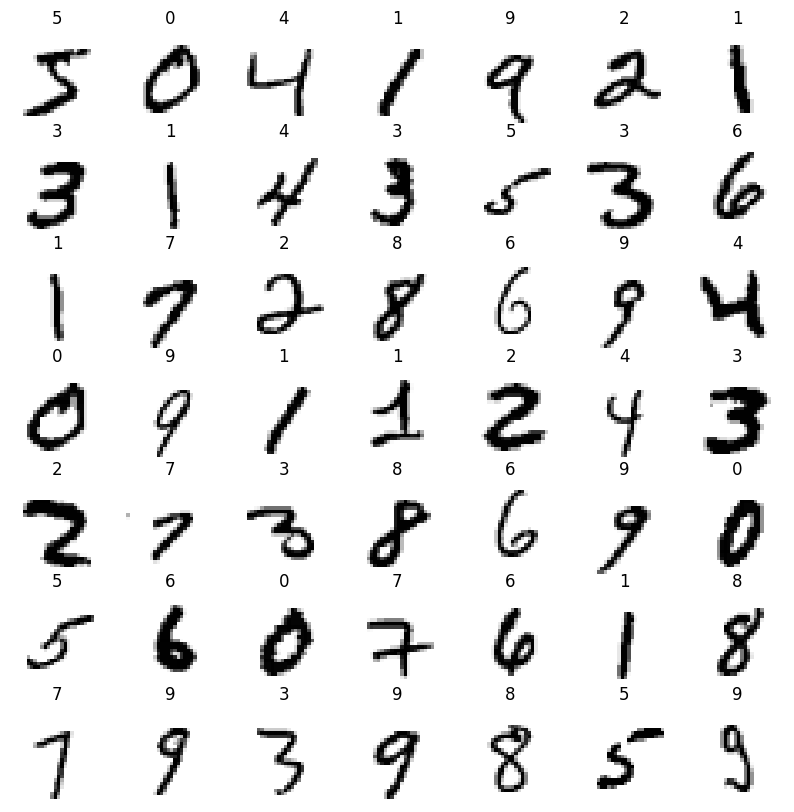

In [4]:
W = 7
L = 7
fig, axes = plt.subplots(W, L, figsize = (10, 10))
axes = axes.ravel()
for i in np.arange(0, W * L):
    axes[i].imshow(x_train[i].reshape((img_rows, img_cols)), cmap="gray_r")
    axes[i].set_title(y_train[i])
    axes[i].axis("off")

# PREPARE THE DATA FOR TRAINING

In [5]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1).astype("float32")/255.0
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1).astype("float32")/255.0

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_test.shape[1]

# BUILD A DEEP LEARNING MODEL

In [6]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (3, 3), activation="relu", input_shape = (img_rows, img_cols, 1))) # reduce layer size to 26 26 32 , activation relu specify input 28 28 1
model.add(Conv2D(64, (3, 3), activation = "relu")) # 24 24 64
model.add(MaxPooling2D(pool_size = (2,2))) # kernel = 2 2 , layer size 12 12 64
model.add(Flatten()) # 12 12 64 -> 9216 1 

model.add(Dense(128, activation = "relu"))
model.add(Dense(num_classes, activation = "softmax"))

model.compile(loss = "categorical_crossentropy",
              optimizer = SGD(0.001),
              metrics = ["accuracy"])

print(model.summary())

c:\Users\Vinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

None


# COMPILE AND TRAIN A DEEP LEARNING MODEL

In [7]:
batch_size = 128 
epochs = 10 
history = model.fit(x_train,
                    y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (x_test, y_test))

score = model.evaluate(x_test, y_test, verbose = 0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.2589 - loss: 2.2798 - val_accuracy: 0.5128 - val_loss: 2.2006
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.5416 - loss: 2.1391 - val_accuracy: 0.7110 - val_loss: 1.7265
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.7425 - loss: 1.4348 - val_accuracy: 0.8501 - val_loss: 0.6664
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.8509 - loss: 0.6092 - val_accuracy: 0.8858 - val_loss: 0.4371
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.8807 - loss: 0.4326 - val_accuracy: 0.8980 - val_loss: 0.3683
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.8930 - loss: 0.3763 - val_accuracy: 0.9080 - val_loss: 0.3335
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.9021 - loss: 0.3453 - val_accuracy: 0.9122 - val_loss: 0.3114
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.9056 - loss: 0.3259 - 

In [8]:
model.save("mnist_simple_cnn_10_epochs.h5")

# ASSESS TRAINED MODEL PERFORMANCE

In [9]:
history_dict = history.history
for k, v in history_dict.items(): print(f"{k}: {v}")

accuracy: [0.3679499924182892, 0.5885999798774719, 0.7817500233650208, 0.8616999983787537, 0.8839333057403564, 0.8954166769981384, 0.9027166962623596, 0.9072666764259338, 0.9123333096504211, 0.9155666828155518]
loss: [2.2581489086151123, 2.0410704612731934, 1.1443876028060913, 0.5466338396072388, 0.41791853308677673, 0.36770814657211304, 0.33919069170951843, 0.31945914030075073, 0.30445724725723267, 0.29161912202835083]
val_accuracy: [0.5127999782562256, 0.7110000252723694, 0.8500999808311462, 0.8858000040054321, 0.8980000019073486, 0.9079999923706055, 0.9121999740600586, 0.9157999753952026, 0.9193999767303467, 0.9232000112533569]
val_loss: [2.2006044387817383, 1.726510763168335, 0.6664263606071472, 0.43705278635025024, 0.3682515323162079, 0.33347412943840027, 0.31139081716537476, 0.2964998185634613, 0.28256553411483765, 0.2706703543663025]


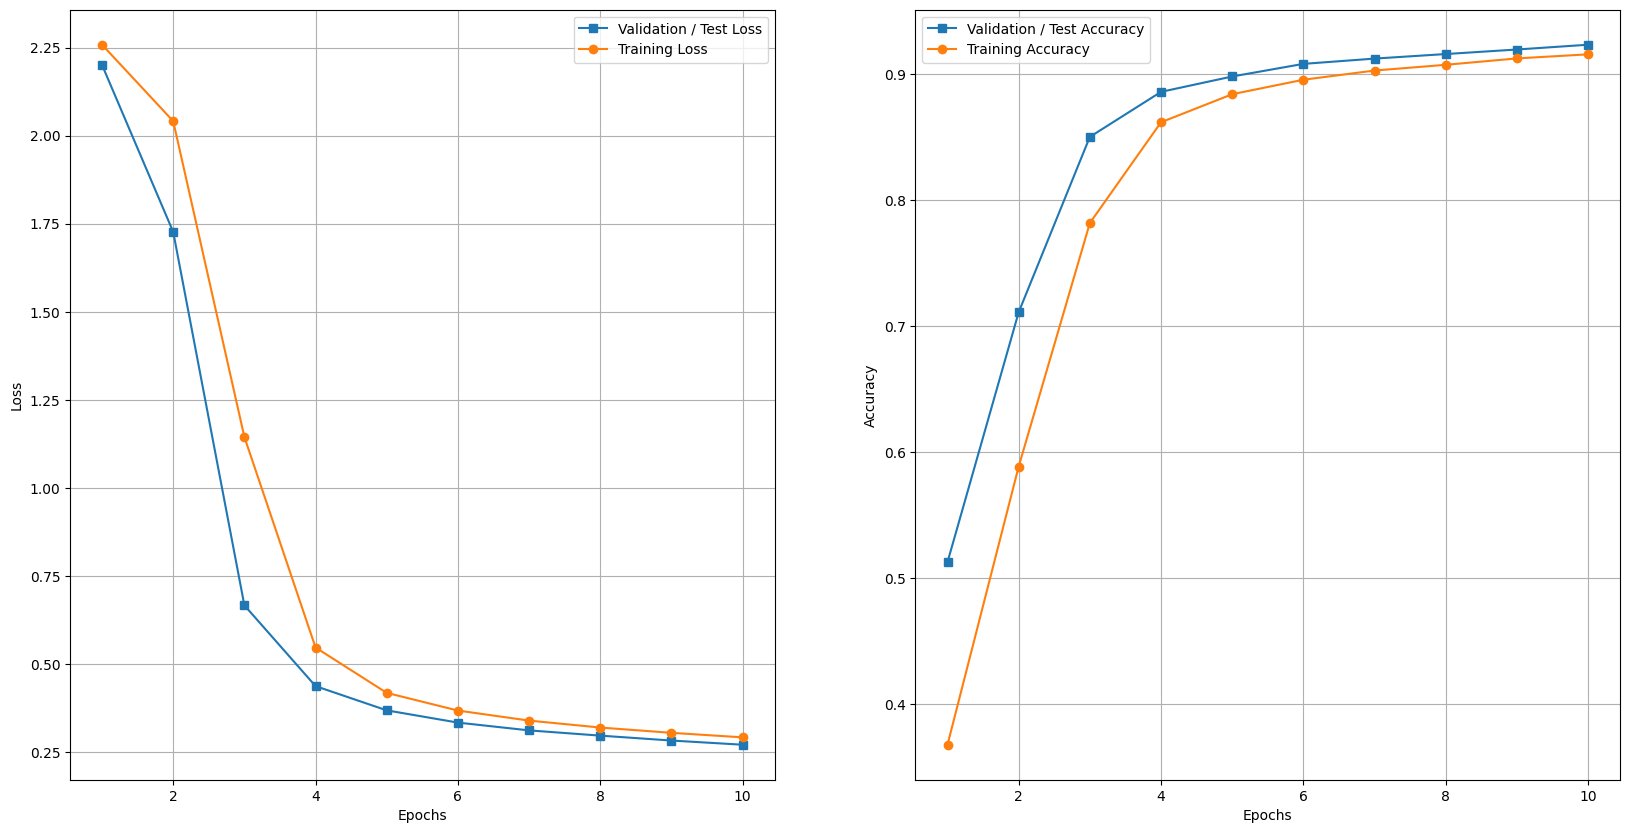

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (20, 10))
epochs = range(1, len(history_dict["loss"]) + 1)

axes[0].plot(epochs, history_dict["val_loss"], label = "Validation / Test Loss", marker = "s")
axes[0].plot(epochs, history_dict["loss"], label = "Training Loss", marker = "o")
axes[0].set_xlabel("Epochs") 
axes[0].set_ylabel("Loss")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(epochs, history_dict["val_accuracy"], label = "Validation / Test Accuracy", marker = "s")
axes[1].plot(epochs, history_dict["accuracy"], label = "Training Accuracy", marker = "o")
axes[1].set_xlabel("Epochs") 
axes[1].set_ylabel("Accuracy")
axes[1].grid(True)
axes[1].legend()

In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = x_test.reshape(10000, 28 , 28 , 1)
classifier = load_model("mnist_simple_cnn_10_epochs.h5")
y_pred = np.argmax(classifier.predict(x_test), axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


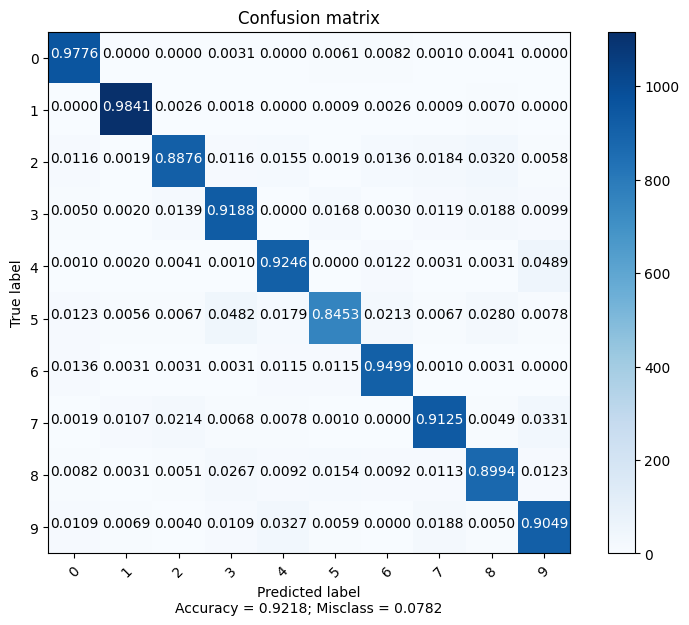

In [12]:
conf_mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat, list(range(0,10)))

In [13]:
class_accuracy = 100 * conf_mat.diagonal() / conf_mat.sum(1)
for (i, ac) in enumerate(class_accuracy): print(f"Class {i} has an accuracy of {ac} %")

Class 0 has an accuracy of 97.75510204081633 %
Class 1 has an accuracy of 98.41409691629956 %
Class 2 has an accuracy of 88.75968992248062 %
Class 3 has an accuracy of 91.88118811881188 %
Class 4 has an accuracy of 92.4643584521385 %
Class 5 has an accuracy of 84.52914798206278 %
Class 6 has an accuracy of 94.98956158663883 %
Class 7 has an accuracy of 91.24513618677042 %
Class 8 has an accuracy of 89.93839835728953 %
Class 9 has an accuracy of 90.48562933597621 %


In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.97      0.98      0.98      1135
           2       0.94      0.89      0.91      1032
           3       0.90      0.92      0.91      1010
           4       0.91      0.92      0.92       982
           5       0.93      0.85      0.88       892
           6       0.93      0.95      0.94       958
           7       0.93      0.91      0.92      1028
           8       0.89      0.90      0.90       974
           9       0.89      0.90      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



# MISSCLASSIFIED PREDICTIONS

In [15]:
result = np.absolute(y_test - y_pred)
misclassified = np.nonzero( result > 0)
print(f"There are {len(misclassified[0])} misclassified predictions")

There are 782 misclassified predictions


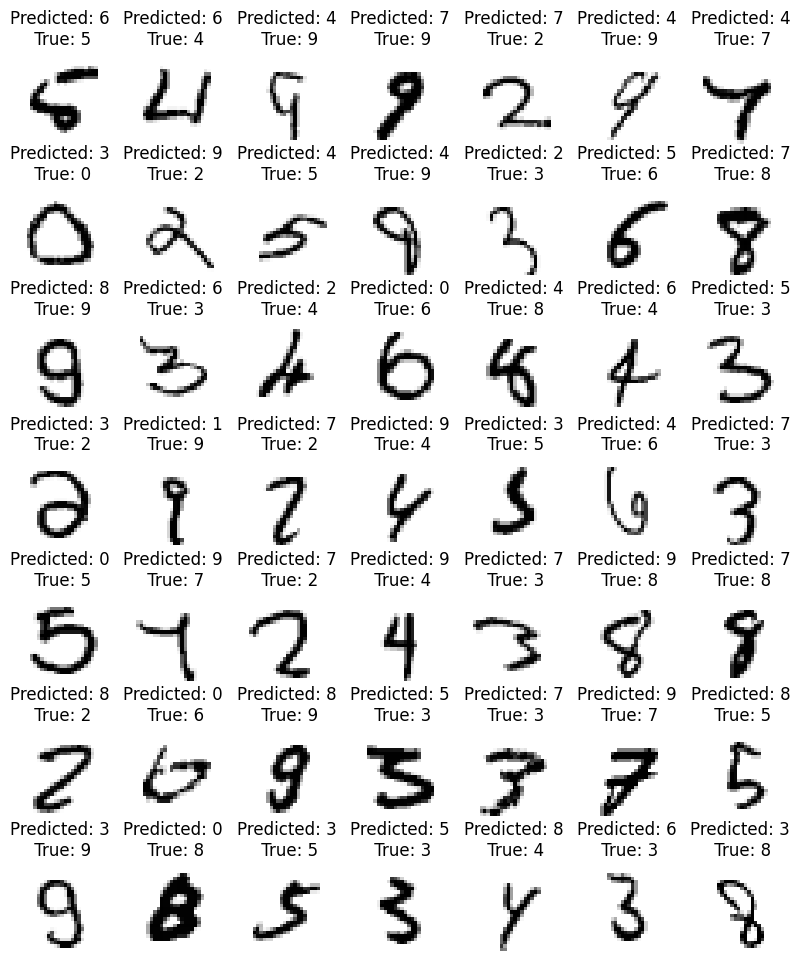

In [16]:
W = 7
L = 7
fig, axes = plt.subplots(W, L, figsize = (10, 12))
axes = axes.ravel()
for i in np.arange(0, W * L):
    axes[i].imshow(x_test[misclassified[0][i]], cmap="gray_r")
    axes[i].set_title(f"Predicted: {y_pred[misclassified[0][i]]}\n True: {y_test[misclassified[0][i]]}")
    axes[i].axis("off")